# Определение стоимости автомобилей

## Введение и задача

Сервис по продаже автомобилей разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо построить модель, которая умеет её определять.

Предоставлены данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.

In [1]:
# pip install lightgbm
# pip install catboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from phik.report import correlation_report, plot_correlation_matrix

In [3]:
RANDOM_STATE = 13

## Загрузка данных и ознакомление

In [4]:
data = pd.read_csv('.../datasets/autos.csv')

In [5]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88187,2016-03-23 20:53:46,4500,small,2012,manual,68,2_reihe,100000,2,gasoline,peugeot,NaN,2016-03-23 00:00:00,0,66113,2016-03-31 22:47:12
118802,2016-03-14 20:58:51,150,small,1997,manual,45,corsa,150000,2,petrol,opel,no,2016-03-14 00:00:00,0,83308,2016-03-16 14:16:50
135540,2016-03-31 11:49:20,800,NaN,1997,NaN,0,voyager,150000,0,petrol,chrysler,NaN,2016-03-31 00:00:00,0,17111,2016-04-06 04:17:44
228274,2016-03-23 17:50:45,8990,sedan,2009,manual,80,golf,80000,11,petrol,volkswagen,NaN,2016-03-23 00:00:00,0,22549,2016-04-05 22:17:32
143457,2016-03-25 11:52:01,600,small,1998,auto,53,swift,150000,2,petrol,suzuki,no,2016-03-25 00:00:00,0,17489,2016-03-28 10:47:40


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Как видно из отчета, данные пестрят пропусками. Также в данных имеются неинформативные колонки, от которых я избавлюсь прежде чем строить корреляционную матрицу.

In [8]:
data = data.drop([
    'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures',
    'PostalCode', 'LastSeen'
],
                 axis=1)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


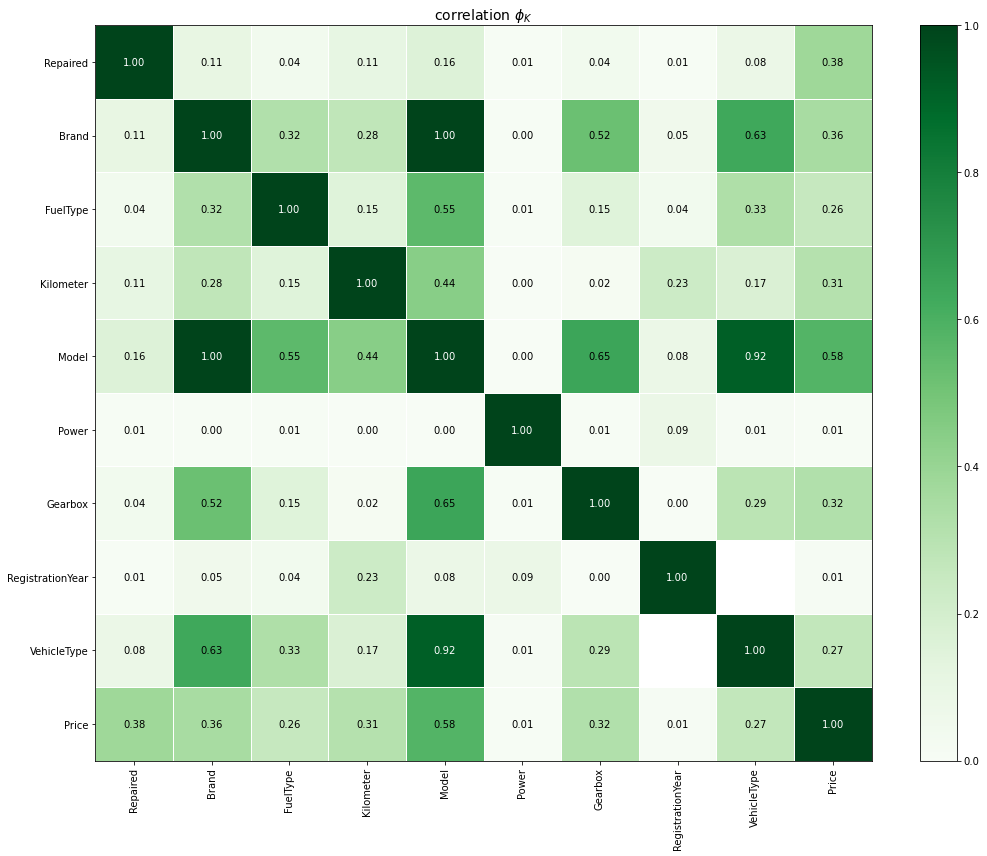

In [9]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 12))
plt.tight_layout();

Четко видно, что цена больше всего коррелирует с моделью автомобиля, что абсолютно логично. Увы, в графе модель много пропусков, думаю, что правильнее всего будет их удалить, т.к. остальные пропуски я планирую восстанавливать в привязке к модели.

## Предобработка данных

### Подготовка данных для заполнения пропусков

#### Коробка передач

In [10]:
gearbox_data = pd.DataFrame(
    data.groupby(by=['Model', 'Gearbox'])['Gearbox'].count())

gearbox_data.columns = ['Count']
gearbox_data.reset_index(inplace=True)

gearbox_data

,Model,Gearbox,Count
0,100,auto,63
1,100,manual,336
2,145,manual,40
3,147,auto,29
4,147,manual,520
...,...,...,...
480,ypsilon,manual,185
481,z_reihe,auto,76
482,z_reihe,manual,625
483,zafira,auto,308


In [11]:
def gearbox(model):
    return gearbox_data.iloc[gearbox_data[gearbox_data['Model'] == model]['Count'].idxmax()]['Gearbox']

#### Тип топлива

In [12]:
data.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [13]:
data.loc[data['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [14]:
data.FuelType.value_counts()

petrol      315072
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [15]:
fuel_data = pd.DataFrame(
    data.groupby(by=['Model', 'FuelType'])['FuelType'].count())

fuel_data.columns = ['Count']
fuel_data.reset_index(inplace=True)

fuel_data

,Model,FuelType,Count
0,100,lpg,8
1,100,petrol,374
2,145,petrol,44
3,147,lpg,18
4,147,petrol,523
...,...,...,...
587,z_reihe,petrol,685
588,zafira,cng,114
589,zafira,hybrid,1
590,zafira,lpg,84


In [16]:
def fuel(model):
    return fuel_data.iloc[fuel_data[fuel_data['Model'] == model]['Count'].idxmax()]['FuelType']

#### Кузов

In [17]:
vtype_data = pd.DataFrame(
    data.groupby(by=['Model', 'VehicleType'])['VehicleType'].count())

vtype_data.columns = ['Count']
vtype_data.reset_index(inplace=True)

vtype_data

,Model,VehicleType,Count
0,100,convertible,1
1,100,coupe,2
2,100,sedan,278
3,100,wagon,109
4,145,coupe,2
...,...,...,...
1126,zafira,other,23
1127,zafira,sedan,22
1128,zafira,small,11
1129,zafira,suv,7


In [18]:
def v_type(model):
    return vtype_data.iloc[vtype_data[vtype_data['Model'] == model]['Count'].idxmax()]['VehicleType']

Подготовил 3 таблицы со сводным количеством типов: коробки передачи, топлива и кузова с привязкой к модели авто. А также 3 фуекции, которые будут выдавать самое частое значение по запросу модели машины.

### Заполнение пропусков

In [19]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

In [20]:
def Nan_replace(row):
    if pd.isna(row['VehicleType']):
        row['VehicleType'] = v_type(row['Model'])
    if pd.isna(row['FuelType']):
        row['FuelType'] = fuel(row['Model'])
    if pd.isna(row['Gearbox']):
        row['Gearbox'] = gearbox(row['Model'])
    return row

Создаю функцию для заполнения пропусков самыми частыми значениями по модели.

In [21]:
data_pr = data.dropna(subset=['Model']).apply(Nan_replace, axis=1)

Убиваю пропуски по модели и применяю функцию

In [22]:
data_pr.fillna('no', inplace=True)

В графе про ремонт очень много пропусков, я считаю, что этот случай, когда пропуск означает нет, и, исходя из этого, заполняю их.

In [23]:
data_pr.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [24]:
round(1 - data_pr.shape[0] / data.shape[0], 2) * 100

6.0

В процессе обработки пропусков ушло 6% фрейма, допустимо.

### Поиск и обработка аномалий

In [25]:
data_pr.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,334664.0,4504.346790,4531.438572,0.0,1150.0,2800.0,6500.0,20000.0
RegistrationYear,334664.0,2003.923992,69.377219,1000.0,1999.0,2003.0,2008.0,9999.0
Power,334664.0,111.373195,185.156439,0.0,70.0,105.0,143.0,20000.0
Kilometer,334664.0,128562.588148,37205.926976,5000.0,125000.0,150000.0,150000.0,150000.0


#### Мощность

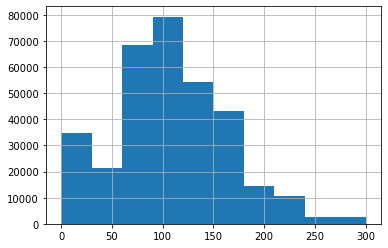

In [26]:
data_pr.Power.hist(range=(0, 300));

Надо побороть машины с нулевым количеством лошадиных сил. Замены проведу по аналогии с пропусками.

In [27]:
power_data = pd.DataFrame(
    data[data.Power != 0].groupby(by=['Model', 'Power'])['Power'].count())

power_data.columns = ['Count']
power_data.reset_index(inplace=True)

power_data

,Model,Power,Count
0,100,55,1
1,100,69,1
2,100,75,1
3,100,82,1
4,100,85,5
...,...,...,...
9226,zafira,1001,1
9227,zafira,1100,1
9228,zafira,1779,2
9229,zafira,1800,1


In [28]:
def power(model):
    return power_data.iloc[power_data[power_data['Model'] == model]['Count'].idxmax()]['Power']
power('corolla')

110

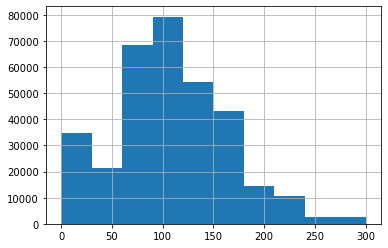

In [33]:
data_pr.Power.hist(range=(0, 300));

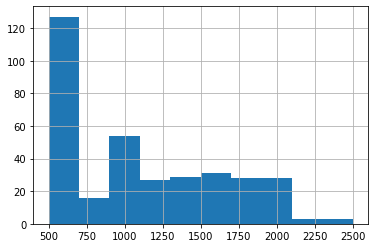

In [34]:
data_pr.Power.hist(range=(500, 2500));

In [35]:
data_pr.query('Power > 550')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,manual,1799,vectra,150000,petrol,opel,yes
4060,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,no
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,no
353493,12500,sedan,2017,manual,2000,other,60000,petrol,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,no


In [36]:
def power_restore_up(row):
    try:
        if row['Power'] > 550:
            row['Power'] = power(row['Model'])
        return row
    except:
        return row 

In [37]:
data_pr = data_pr.apply(power_restore_up, axis=1)

Аналогично причесал данные по машинам больше 550 лошадей и убил данные по машинам меньше 10 лошадей.

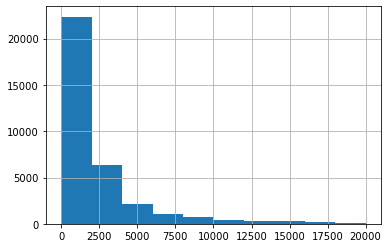

In [39]:
data_pr.query('Power == 0')['Price'].hist();

#### Год регистрации

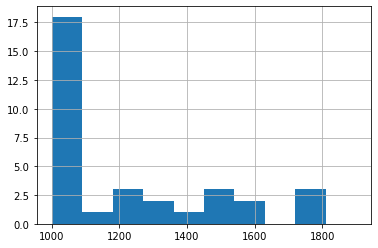

In [40]:
data_pr.RegistrationYear.hist(range=(1000, 1900));

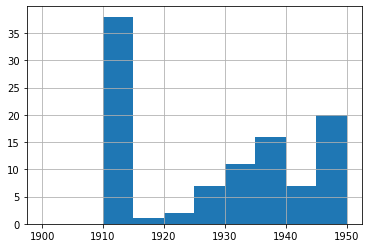

In [41]:
data_pr.RegistrationYear.hist(range=(1900, 1950));

In [42]:
data_pr.query('RegistrationYear<1930').shape[0]

81

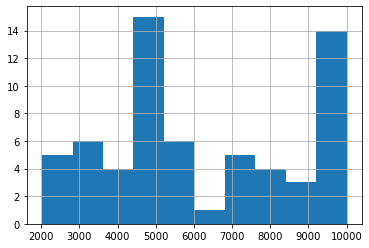

In [43]:
data_pr.RegistrationYear.hist(range=(2024, 9999));

In [44]:
data_pr.query('RegistrationYear>2023').shape[0]

63

In [45]:
data_pr = data_pr.query('RegistrationYear>1930 and RegistrationYear<=2016')

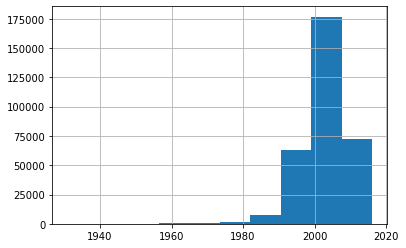

In [46]:
data_pr.RegistrationYear.hist();

По году регистрации считаю проще всего просто убить аномалии (младше 1930 года (коллекционные) и старше 2023).

#### Цена

In [47]:
data_pr.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,322097.0,4556.034108,4560.419235,0.0,1150.0,2899.0,6550.0,20000.0
RegistrationYear,322097.0,2002.670202,6.632094,1931.0,1999.0,2003.0,2007.0,2016.0
Power,322097.0,108.966290,61.918885,0.0,72.0,105.0,143.0,550.0
Kilometer,322097.0,128435.160837,37218.324920,5000.0,125000.0,150000.0,150000.0,150000.0


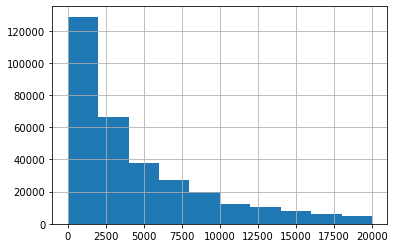

In [48]:
data_pr.Price.hist();

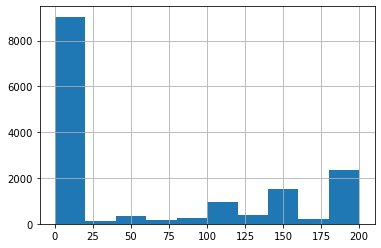

In [49]:
data_pr.Price.hist(range=(0, 200));

In [50]:
data_pr.query('Price<100')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,small,1990,manual,0,corsa,150000,petrol,opel,no
89,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
154,0,sedan,2006,manual,0,other,5000,petrol,fiat,no
...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,no
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,no
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


In [51]:
data_pr = data_pr.query('Price>99')

In [52]:
data_pr.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,312129.0,4701.343948,4558.431636,100.0,1250.0,2999.0,6800.0,20000.0
RegistrationYear,312129.0,2002.771053,6.550209,1931.0,1999.0,2003.0,2007.0,2016.0
Power,312129.0,110.015378,61.348639,0.0,75.0,105.0,143.0,550.0
Kilometer,312129.0,128532.545838,36844.728569,5000.0,125000.0,150000.0,150000.0,150000.0


В разделе цена было очень много машин меньше 100 евро и бесплатных. На мой взгляд их надо просто убрать, учитывая, что цена наш целевой показатель.

In [53]:
round(1 - data_pr.shape[0] / data.shape[0], 2) * 100

12.0

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


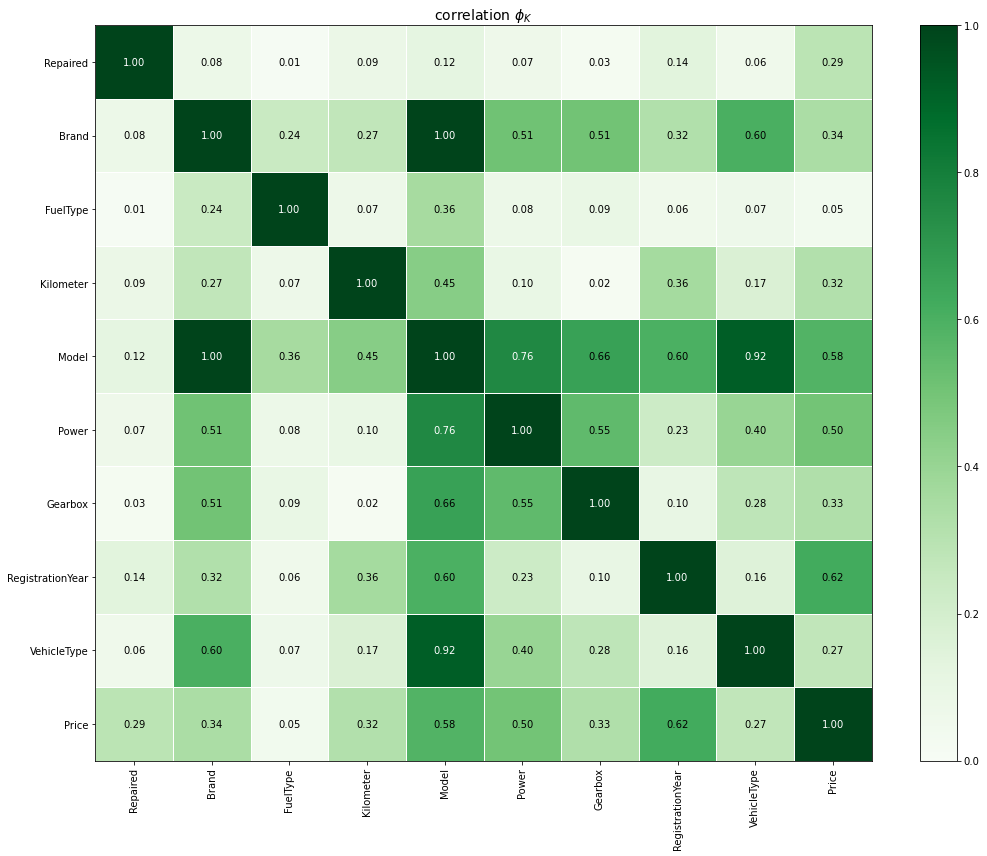

In [54]:
phik_overview = data_pr.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 12))
plt.tight_layout();

В ходе предобработки данных были удалены пропуски по моделям, остальные пропуски были заменены с привязкой к модели. Аномалии были обработаны аналогично. Не поддающиеся обработке аномалии были удалены. В ходе предобработки было утеряно 9% фрейма, что допустимо.

## Разделение выборок и подготовка признаков

### Разделение выборок

In [55]:
features = data_pr.drop('Price', axis=1) 
target = data_pr.Price

In [56]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

print(target_train.shape[0])
print(target_test.shape[0])

234096
78033


In [57]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=RANDOM_STATE)

print(target_train.shape[0])
print(target_valid.shape[0])

175572
58524


Разделяю данные, стандартная процедура.

### Scailing

In [58]:
scaler_ss = StandardScaler()

In [59]:
feautures_scaled = features_train.copy()

feautures_scaled[['RegistrationYear', 'Power', 'Kilometer']] = scaler_ss.fit_transform(
    feautures_scaled[['RegistrationYear', 'Power', 'Kilometer']])

feautures_scaled

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
298365,small,-1.481753,manual,-1.061105,polo,0.583965,petrol,volkswagen,no
225614,small,-0.113268,manual,-0.816608,lupo,0.583965,petrol,volkswagen,yes
17927,wagon,1.559325,manual,-0.148319,focus,-2.401392,petrol,ford,no
265368,wagon,2.015486,auto,0.487371,passat,0.583965,petrol,volkswagen,yes
299405,sedan,-0.265322,manual,-0.083120,leon,0.583965,lpg,seat,no
...,...,...,...,...,...,...,...,...,...
342560,convertible,-0.417376,auto,2.280343,clk,0.583965,petrol,mercedes_benz,no
130534,bus,0.799055,manual,-0.017921,sprinter,0.583965,petrol,mercedes_benz,no
125416,wagon,1.711379,manual,0.487371,insignia,-1.315808,petrol,opel,no
56968,small,0.342894,manual,-0.849208,twingo,0.583965,petrol,renault,no


In [60]:
features_valid_scaled = features_valid.copy()

features_valid_scaled[['RegistrationYear', 'Power', 'Kilometer']] = scaler_ss.transform(
    features_valid_scaled[['RegistrationYear', 'Power', 'Kilometer']])

features_valid_scaled

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1233,wagon,-0.113268,manual,-0.246117,kangoo,0.583965,petrol,renault,yes
305116,sedan,-1.025591,auto,0.193976,c_klasse,0.583965,petrol,mercedes_benz,no
65455,wagon,0.190840,manual,0.242875,vectra,0.583965,petrol,opel,no
57151,bus,0.647001,manual,0.487371,touran,0.583965,petrol,volkswagen,no
220591,wagon,-0.721483,auto,0.650369,passat,0.583965,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...
151863,bus,-0.873537,manual,0.177676,other,0.583965,petrol,fiat,yes
90556,wagon,0.799055,auto,0.487371,passat,0.583965,petrol,volkswagen,no
339129,wagon,1.255217,manual,0.894865,zafira,-2.672788,petrol,opel,no
113557,bus,0.494948,manual,0.487371,b_klasse,0.583965,petrol,mercedes_benz,no


In [61]:
features_test_scaled = features_test.copy()

features_test_scaled[['RegistrationYear', 'Power', 'Kilometer']] = scaler_ss.transform(
    features_test_scaled[['RegistrationYear', 'Power', 'Kilometer']])

features_test_scaled

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
303439,coupe,0.494948,auto,6.355280,other,0.583965,petrol,mercedes_benz,no
162923,sedan,-0.569430,manual,-1.794593,3er,0.583965,petrol,bmw,no
128978,small,-0.569430,manual,-0.572112,3_reihe,0.583965,petrol,peugeot,no
186921,sedan,0.190840,manual,0.976364,s60,0.583965,petrol,volvo,no
100523,wagon,-0.569430,manual,0.161376,primera,0.583965,petrol,nissan,no
...,...,...,...,...,...,...,...,...,...
40162,sedan,-1.177645,manual,0.096177,3er,0.583965,petrol,bmw,no
12612,sedan,2.015486,manual,-1.794593,a_klasse,-2.944184,petrol,mercedes_benz,no
296014,convertible,0.342894,auto,1.970648,clk,-0.094525,petrol,mercedes_benz,no
197429,sedan,1.255217,manual,0.340674,astra,-1.587204,petrol,opel,no


Делаю апскейл.

### Encoding

In [62]:
cat_columns =  features.select_dtypes('object').columns

feautures_scaled.reset_index(drop=True, inplace=True)
features_valid_scaled.reset_index(drop=True, inplace=True)
features_test_scaled.reset_index(drop=True, inplace=True)

In [63]:
ohe = OneHotEncoder(sparse=False, drop='first')

In [64]:
feautures_scaled_ohe = ohe.fit_transform(feautures_scaled[cat_columns])
feautures_scaled_ohe = pd.DataFrame(feautures_scaled_ohe, columns=ohe.get_feature_names())
feautures_scaled_ohe = feautures_scaled.drop(columns=cat_columns).join(feautures_scaled_ohe)
feautures_scaled_ohe = feautures_scaled_ohe.set_index(features_train.index)

feautures_scaled_ohe

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_seat,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_yes
298365,-1.481753,-1.061105,0.583965,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
225614,-0.113268,-0.816608,0.583965,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17927,1.559325,-0.148319,-2.401392,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265368,2.015486,0.487371,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
299405,-0.265322,-0.083120,0.583965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342560,-0.417376,2.280343,0.583965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130534,0.799055,-0.017921,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125416,1.711379,0.487371,-1.315808,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56968,0.342894,-0.849208,0.583965,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
features_valid_scaled_ohe = ohe.transform(features_valid_scaled[cat_columns])
features_valid_scaled_ohe = pd.DataFrame(features_valid_scaled_ohe, columns=ohe.get_feature_names())
features_valid_scaled_ohe = features_valid_scaled.drop(columns=cat_columns).join(features_valid_scaled_ohe)
features_valid_scaled_ohe = features_valid_scaled_ohe.set_index(features_valid.index)

features_valid_scaled_ohe

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_seat,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_yes
1233,-0.113268,-0.246117,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
305116,-1.025591,0.193976,0.583965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65455,0.190840,0.242875,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57151,0.647001,0.487371,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
220591,-0.721483,0.650369,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151863,-0.873537,0.177676,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90556,0.799055,0.487371,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
339129,1.255217,0.894865,-2.672788,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113557,0.494948,0.487371,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
features_test_scaled_ohe = ohe.transform(features_test_scaled[cat_columns])
features_test_scaled_ohe = pd.DataFrame(features_test_scaled_ohe, columns=ohe.get_feature_names())
features_test_scaled_ohe = features_test_scaled.drop(columns=cat_columns).join(features_test_scaled_ohe)
features_test_scaled_ohe = features_test_scaled_ohe.set_index(features_test.index)

features_test_scaled_ohe

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_seat,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_yes
303439,0.494948,6.355280,0.583965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162923,-0.569430,-1.794593,0.583965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128978,-0.569430,-0.572112,0.583965,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186921,0.190840,0.976364,0.583965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100523,-0.569430,0.161376,0.583965,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40162,-1.177645,0.096177,0.583965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12612,2.015486,-1.794593,-2.944184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296014,0.342894,1.970648,-0.094525,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197429,1.255217,0.340674,-1.587204,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
oe = OrdinalEncoder()

In [68]:
feautures_scaled_oe = oe.fit_transform(feautures_scaled[cat_columns])
feautures_scaled_oe = pd.DataFrame(feautures_scaled_oe, columns=cat_columns)
feautures_scaled_oe = feautures_scaled.drop(columns=cat_columns).join(feautures_scaled_oe)
feautures_scaled_oe = feautures_scaled_oe.set_index(features_train.index)

feautures_scaled_oe

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
298365,-1.481753,-1.061105,0.583965,5.0,1.0,173.0,5.0,37.0,0.0
225614,-0.113268,-0.816608,0.583965,5.0,1.0,143.0,5.0,37.0,1.0
17927,1.559325,-0.148319,-2.401392,7.0,1.0,103.0,5.0,10.0,0.0
265368,2.015486,0.487371,0.583965,7.0,0.0,170.0,5.0,37.0,1.0
299405,-0.265322,-0.083120,0.583965,4.0,1.0,140.0,3.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...
342560,-0.417376,2.280343,0.583965,1.0,0.0,76.0,5.0,20.0,0.0
130534,0.799055,-0.017921,0.583965,0.0,1.0,213.0,5.0,20.0,0.0
125416,1.711379,0.487371,-1.315808,7.0,1.0,122.0,5.0,24.0,0.0
56968,0.342894,-0.849208,0.583965,5.0,1.0,227.0,5.0,27.0,0.0


In [69]:
features_valid_scaled_oe = oe.transform(features_valid_scaled[cat_columns])
features_valid_scaled_oe = pd.DataFrame(features_valid_scaled_oe, columns=cat_columns)
features_valid_scaled_oe = features_valid_scaled.drop(columns=cat_columns).join(features_valid_scaled_oe)
features_valid_scaled_oe = features_valid_scaled_oe.set_index(features_valid.index)

features_valid_scaled_oe

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
1233,-0.113268,-0.246117,0.583965,7.0,1.0,133.0,5.0,27.0,1.0
305116,-1.025591,0.193976,0.583965,4.0,0.0,59.0,5.0,20.0,0.0
65455,0.190840,0.242875,0.583965,7.0,1.0,234.0,5.0,24.0,0.0
57151,0.647001,0.487371,0.583965,0.0,1.0,222.0,5.0,37.0,0.0
220591,-0.721483,0.650369,0.583965,7.0,0.0,170.0,5.0,37.0,0.0
...,...,...,...,...,...,...,...,...,...
151863,-0.873537,0.177676,0.583965,0.0,1.0,166.0,5.0,9.0,1.0
90556,0.799055,0.487371,0.583965,7.0,0.0,170.0,5.0,37.0,0.0
339129,1.255217,0.894865,-2.672788,7.0,1.0,249.0,5.0,24.0,0.0
113557,0.494948,0.487371,0.583965,0.0,1.0,47.0,5.0,20.0,0.0


In [70]:
features_test_scaled_oe = oe.transform(features_test_scaled[cat_columns])
features_test_scaled_oe = pd.DataFrame(features_test_scaled_oe, columns=cat_columns)
features_test_scaled_oe = features_test_scaled.drop(columns=cat_columns).join(features_test_scaled_oe)
features_test_scaled_oe = features_test_scaled_oe.set_index(features_test.index)

features_test_scaled_oe

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
303439,0.494948,6.355280,0.583965,2.0,0.0,166.0,5.0,20.0,0.0
162923,-0.569430,-1.794593,0.583965,4.0,1.0,11.0,5.0,2.0,0.0
128978,-0.569430,-0.572112,0.583965,5.0,1.0,10.0,5.0,25.0,0.0
186921,0.190840,0.976364,0.583965,4.0,1.0,191.0,5.0,38.0,0.0
100523,-0.569430,0.161376,0.583965,7.0,1.0,174.0,5.0,23.0,0.0
...,...,...,...,...,...,...,...,...,...
40162,-1.177645,0.096177,0.583965,4.0,1.0,11.0,5.0,2.0,0.0
12612,2.015486,-1.794593,-2.944184,4.0,1.0,33.0,5.0,20.0,0.0
296014,0.342894,1.970648,-0.094525,1.0,0.0,76.0,5.0,20.0,0.0
197429,1.255217,0.340674,-1.587204,4.0,1.0,42.0,5.0,24.0,0.0


Кодирую через ОНЕ для линейной регрессии и через ОЕ для всех остальных

In [71]:
del data
del data_pr
del features
del target
del features_test
del features_test_scaled
del features_valid
del features_valid_scaled
del features_train
del feautures_scaled

Удаляю лишние фреймы, чтобы не грузить памать.

Данные разделены на тренировочные - 56%, валидационные - 19% и тестовые - 25%. Провел масштабирование для улучшения обучения, а также кодирование признаков.

## Обучение

In [72]:
fin_data = pd.DataFrame(index= ['RMSE', 'Time_fit', 'Time_pred'])

Создаю таблицу, в которую буду собирать время и метрику.

### Linear Regression

In [73]:
LR = LinearRegression()

In [74]:
start = time.time()
LR.fit(feautures_scaled_ohe, target_train)
end = time.time()
LR_time_fit = end - start

start = time.time()
pred = LR.predict(features_valid_scaled_ohe)
end = time.time()
LR_time_pred = end - start

RMSE_LR = mean_squared_error(target_valid, pred)**0.5

print(RMSE_LR, LR_time_fit, LR_time_pred)

2684.8356221131803 1.2646358013153076 0.01295781135559082


In [75]:
fin_data['LinReg'] = [RMSE_LR, LR_time_fit, LR_time_pred]

### Decision Tree

In [76]:
DT = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [77]:
%%time
DT.fit(feautures_scaled_oe, target_train)
pred = DT.predict(features_valid_scaled_oe)
mean_squared_error(target_valid, pred)**0.5

CPU times: total: 359 ms
Wall time: 351 ms


1957.1586586821998

In [78]:
DTR_params = {'max_depth': range(3, 15)}

DTR_GR = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                        param_grid=DTR_params,
                        scoring='neg_mean_squared_error',
                        verbose=1,
                        n_jobs=-1)

In [79]:
%%time
DTR_GR.fit(feautures_scaled_oe, target_train)
DTR_GR.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 625 ms
Wall time: 1.76 s


DecisionTreeRegressor(max_depth=13, random_state=13)

In [80]:
DT = DecisionTreeRegressor(random_state = RANDOM_STATE, max_depth=13)

start = time.time()
DT.fit(feautures_scaled_oe, target_train)
end = time.time()
DT_time_fit = end - start

start = time.time()
pred = DT.predict(features_valid_scaled_oe)
end = time.time()
DT_time_pred = end - start

RMSE_DT = mean_squared_error(target_valid, pred)**0.5


print(RMSE_DT, DT_time_fit, DT_time_pred)

1889.5006954172175 0.2193000316619873 0.00594639778137207


In [81]:
fin_data['DecTree'] = [RMSE_DT, DT_time_fit, DT_time_pred]

### Random Forest

In [82]:
RF = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [83]:
%%time
RF.fit(feautures_scaled_oe, target_train)

CPU times: total: 37 s
Wall time: 2.04 s


RandomForestRegressor(n_jobs=-1, random_state=13)

In [84]:
pred = RF.predict(features_valid_scaled_oe)

In [85]:
mean_squared_error(target_valid, pred)**0.5

1627.7507323693899

In [86]:
RF_params = {'max_depth': range(3, 15), 'n_estimators': (150, 251, 10)}

RF_GR = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                     param_grid=RF_params,
                     scoring='neg_mean_squared_error',
                     verbose=1,
                     n_jobs=-1)

In [87]:
%%time
RF_GR.fit(feautures_scaled_oe, target_train)
RF_GR.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 38 s
Wall time: 6min 11s


RandomForestRegressor(max_depth=14, n_estimators=251, random_state=13)

In [88]:
RF = RandomForestRegressor(random_state = RANDOM_STATE, max_depth=14, n_estimators=251, n_jobs=-1)

start = time.time()
RF.fit(feautures_scaled_oe, target_train)
end = time.time()
RF_time_fit = end - start

start = time.time()
pred = RF.predict(features_valid_scaled_oe)
end = time.time()
RF_time_pred = end - start

RMSE_RF = mean_squared_error(target_valid, pred)**0.5

print(RMSE_RF, RF_time_fit, RF_time_pred)

1675.8163798200785 3.535658836364746 0.10564637184143066


In [89]:
fin_data['RandFor'] = [RMSE_RF, RF_time_fit, RF_time_pred]

### CAT BOOST

In [90]:
CAT = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE')

In [91]:
start = time.time()
CAT.fit(feautures_scaled_oe, target_train)
end = time.time()
CAT_time_fit = end - start

start = time.time()
pred = CAT.predict(features_valid_scaled_oe)
end = time.time()
CAT_time_pred = end - start

RMSE_CAT = mean_squared_error(target_valid, pred)**0.5

print(RMSE_CAT, CAT_time_fit, CAT_time_pred)

Learning rate set to 0.092641
0:	learn: 4291.7947919	total: 161ms	remaining: 2m 41s
1:	learn: 4053.1029289	total: 173ms	remaining: 1m 26s
2:	learn: 3835.2046787	total: 185ms	remaining: 1m 1s
3:	learn: 3643.7144287	total: 197ms	remaining: 49s
4:	learn: 3470.1803822	total: 204ms	remaining: 40.6s
5:	learn: 3316.0620024	total: 211ms	remaining: 34.9s
6:	learn: 3177.6158548	total: 217ms	remaining: 30.8s
7:	learn: 3058.3295490	total: 224ms	remaining: 27.7s
8:	learn: 2951.2324342	total: 229ms	remaining: 25.2s
9:	learn: 2856.9718374	total: 234ms	remaining: 23.1s
10:	learn: 2771.0593341	total: 239ms	remaining: 21.5s
11:	learn: 2696.0904152	total: 243ms	remaining: 20s
12:	learn: 2626.3559001	total: 248ms	remaining: 18.8s
13:	learn: 2568.2090565	total: 252ms	remaining: 17.8s
14:	learn: 2512.4147578	total: 257ms	remaining: 16.9s
15:	learn: 2466.3516148	total: 262ms	remaining: 16.1s
16:	learn: 2423.6668225	total: 266ms	remaining: 15.4s
17:	learn: 2387.3375686	total: 270ms	remaining: 14.8s
18:	learn:

In [92]:
fin_data['CATBOOST'] = [RMSE_CAT, CAT_time_fit, CAT_time_pred]

### LGBMR

In [93]:
LGBMR = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)

In [94]:
%%time
LGBMR.fit(feautures_scaled_oe, target_train)
pred = LGBMR.predict(features_valid_scaled_oe)
print(mean_squared_error(target_valid, pred)**0.5)

1711.2824511257988
CPU times: total: 3.12 s
Wall time: 266 ms


In [95]:
LGBMR_params = {
    'num_leaves': range(100, 201, 20),
    'max_depth': range(5, 11, 1),
    'n_estimators': range(200, 351, 50)
}

LGBMR_GR = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE),
                        param_grid=LGBMR_params,
                        scoring='neg_mean_squared_error',
                        verbose=1,
                        n_jobs=-1)

In [96]:
%%time
LGBMR_GR.fit(feautures_scaled_oe, target_train, verbose=0)
LGBMR_GR.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
CPU times: total: 29.3 s
Wall time: 3min 23s


LGBMRegressor(max_depth=10, n_estimators=350, num_leaves=180, random_state=13)

In [97]:
LGBMR = LGBMRegressor(random_state = RANDOM_STATE, max_depth=10, n_estimators=350, num_leaves=200, n_jobs=-1)

start = time.time()
LGBMR.fit(feautures_scaled_oe, target_train)
end = time.time()
LGBMR_time_fit = end - start

start = time.time()
pred = LGBMR.predict(features_valid_scaled_oe)
end = time.time()
LGBMR_time_pred = end - start

RMSE_LGBMR = mean_squared_error(target_valid, pred)**0.5

print(RMSE_LGBMR, LGBMR_time_fit, LGBMR_time_pred)

1547.7306865666264 0.9927396774291992 0.13947319984436035


In [98]:
fin_data['LGBMR'] = [RMSE_LGBMR, LGBMR_time_fit, LGBMR_time_pred]

### DUMMY

In [99]:
Dumm = DummyRegressor()

start = time.time()
Dumm.fit(feautures_scaled_oe, target_train)
end = time.time()
Dumm_time_fit = end - start

start = time.time()
pred = Dumm.predict(features_valid_scaled_oe)
end = time.time()
Dumm_time_pred = end - start

RMSE_Dumm = mean_squared_error(target_valid, pred)**0.5

print(RMSE_Dumm, Dumm_time_fit, Dumm_time_pred)

4546.475398128929 0.0 0.0009968280792236328


In [100]:
fin_data['Dumm'] = [RMSE_Dumm, Dumm_time_fit, Dumm_time_pred]

In [101]:
fin_data = round(fin_data.T, 2)

In [102]:
fin_data.sort_values(by='RMSE')

,RMSE,Time_fit,Time_pred
LGBMR,1547.73,0.99,0.14
CATBOOST,1624.51,4.45,0.01
RandFor,1675.82,3.54,0.11
DecTree,1889.50,0.22,0.01
LinReg,2684.84,1.26,0.01
Dumm,4546.48,0.00,0.00


Было обучено 5 моделей, для 3 из них гиперпараметры подбирались через Гридсерч, это приводило к переобучению модели из-за утечки данных через апскейл, но я, к своему стыду, не успел осилить пайплайны. По итогу тестирования моделей на валидационной выборке лучшая по метрике модель была LGBMR, которая показала при этом вполне хорошее время обучения и предсказания. Считаю, что 0,99 и 0,14 секунды на обучение и предсказание вполне себе приемлемо, поэтому на этой модели провожу финальное тестирование.

## Проверка на тестовой выборке и финальный вывод

In [103]:
pred_test = LGBMR.predict(features_test_scaled_oe)
RMSE_test = mean_squared_error(target_test, pred_test)**0.5
print(RMSE_test)

1558.4316395927656


В рамках данной работы был проведен анализ данных по продаже автомобилей с целью обучения модели, предсказывающей цену автомобиля на основании признаков: модель, мощность, год регистрации и др. 
Для достижения указанной цели была проведена предобработка данных, удалены и заменены пропуски и аномалии. Далее данные были масшатбированы и закодированы для лучшей работы моделей машинного обучения. В качестве метрики был принят корень средней квадратной ошибки.
По итогу тестирования 5 различных моделей, было установлено, что случайная модель демонстрирует уровень метрики 4533. Лучшая модель имела уровень метрики 1547 на валидационных тестах и 1558 на тестовой выборке. Очень радует малый разброс между результатами, что может говорить о том, что гиперпараметры подобраны оптимально и модель не переобучена.